In [1]:
%load_ext autotime
import pandas as pd  # Tabular data
from glob import glob  # File pattern matching
import os  # Operating System
import geopandas as gpd  # Geospatial data
import re  # Regular expressions
import math
from tqdm.auto import tqdm  # Progress bars
from tqdm.contrib.concurrent import thread_map, process_map  # Parallel operations
import rapidfuzz # Fuzzy string matching
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 130)

import platform
if platform.system() == "Windows":
  prefix = "Z:/"
else:
  prefix = "ressci201900060-RNC2-Coastal/"

df = pd.concat(pd.read_csv(f) for f in ["meta.csv"])
# Filter to just shapefiles that have the CPS column defined
df = df[df.CPS & (df.n_lines > 0)]
df["Pixel_ER"] = (
    df.res.str.replace("(", "", regex=False).str.split(",").str[0].astype(float)
)
#df = df[["filename", "matched_image", "Pixel_ER"]]
# Testing with BigBay
# df = df[df.filename.str.contains("BigBay")]
df

,filename,matched_image,match_score,Source,n_lines,CPS,Photoscale,Pixel_Er,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,compress,interleave,GCPs,res,photometric,Pixel_ER
0,Retrolens/Northland/Houhora/Shorelines/Houhora_20FEB1984.shp,Retrolens/Northland/Houhora/Stack/Houhora_20FEB1984.tif,100.0,RL,7,True,True,True,GTiff,uint16,65535.0,30456,32719,1,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.40, 0.00, 1613948.18|\n| 0.00,-0.40, 6149385.93|\n| 0.00, 0.00, 1.00|",128.0,128,True,lzw,band,0,"(0.40232855969999476, 0.40232855969999476)",NaN,0.402329
1,Retrolens/Northland/MarsdenPoint/Shorelines/MarsdenPoint_11MAY1968.shp,Retrolens/Northland/MarsdenPoint/Stack/MarsdenPoint_11MAY1968_mosiac.jp2,100.0,RL,1,True,True,True,JP2OpenJPEG,uint16,256.0,13769,13364,1,NaN,"| 0.33, 0.00, 1731198.14|\n| 0.00,-0.33, 6033901.29|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,NaN,6,"(0.32666823639999026, 0.3266682363999882)",NaN,0.326668
2,Retrolens/Northland/MarsdenPoint/Shorelines/MarsdenPoint_10JAN1979.shp,Retrolens/Northland/MarsdenPoint/Stack/MarsdenPoint_10JAN1979_mosaic.jp2,100.0,RL,1,True,True,True,JP2OpenJPEG,uint16,256.0,22123,28945,1,NaN,"| 0.34, 0.00, 1728272.28|\n| 0.00,-0.34, 6035660.22|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,NaN,6,"(0.3432434214000076, 0.3432434214000093)",NaN,0.343243
3,Retrolens/Canterbury/OpihiRiver_RangitataRiver/Shorelines/OpihiRiver_RangitataRiver_9SEP1954.shp,Retrolens/Canterbury/OpihiRiver_RangitataRiver/Stack/OpihiRiver_RangitataRiver_9SEP1954_mosaic.jp2,100.0,RL,7,True,True,True,JP2OpenJPEG,uint16,256.0,17555,13288,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.50, 0.00, 1473975.57|\n| 0.00,-0.50, 5107925.72|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,pixel,0,"(0.5, 0.5)",NaN,0.500000
4,Retrolens/Canterbury/OpihiRiver_OrariRiver/Shorelines/OpihiRiver_OrariRiver_19FEB1977.shp,Retrolens/Canterbury/OpihiRiver_OrariRiver/Stack/OpihiRiver_OrariRiver_19FEB1977_mosaic.jp2,100.0,RL,7,True,True,True,JP2OpenJPEG,uint16,256.0,10888,8385,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.70, 0.00, 1467717.29|\n| 0.00,-0.70, 5101742.99|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,pixel,0,"(0.7000000000000085, 0.7)",NaN,0.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,Retrolens/Taranaki/NewPlymouth/Shorelines/NewPlymouth_14AUG1950_cliff.shp,Retrolens/Taranaki/NewPlymouth/Stack/NewPlymouth_14AUG1950_mosaic.jp2,100.0,RL,13,True,True,True,JP2OpenJPEG,uint16,256.0,56494,32665,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.20, 0.00, 1685313.71|\n| 0.00,-0.20, 5678879.03|\n| 0.00, 0.00, 1.00|",NaN,32665,False,NaN,pixel,0,"(0.20000000000000082, 0.2)",NaN,0.200000
1909,Retrolens/Taranaki/NewPlymouth/Shorelines/NewPlymouth_14AUG1950_beach.shp,Retrolens/Taranaki/NewPlymouth/Stack/NewPlymouth_14AUG1950_mosaic.jp2,100.0,RL,8,True,True,True,JP2OpenJPEG,uint16,256.0,56494,32665,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.20, 0.00, 1685313.71|\n| 0.00,-0.20, 5678879.03|\n| 0.00, 0.00, 1.00|",NaN,32665,False,NaN,pixel,0,"(0.20000000000000082, 0.2)",NaN,0.200000
1910,Retrolens/Taranaki/UrenuiRiver_North_AOI/Shorelines/UrenuiRiver_North_5MAR1943.shp,Retrolens/Taranaki/UrenuiRiver_North_AOI/Stack/UrenuiRiver_North_5MAR1943_mosaic.jp2,100.0,RLN,42,True,True,True,JP2OpenJPEG,uint16,256.0,16369,17612,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.50, 0.00, 171

In [2]:
df = pd.concat((df, pd.read_csv(prefix+"Nick/LDS_matches.csv")))
df

,filename,matched_image,match_score,Source,n_lines,CPS,Photoscale,Pixel_Er,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,compress,interleave,GCPs,res,photometric,Pixel_ER,matched_index_tiles,date,DSASDate,matched_date,matched_date_col
0,Retrolens/Northland/Houhora/Shorelines/Houhora_20FEB1984.shp,Retrolens/Northland/Houhora/Stack/Houhora_20FEB1984.tif,100.0,RL,7.0,True,True,True,GTiff,uint16,65535.0,30456.0,32719.0,1.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.40, 0.00, 1613948.18|\n| 0.00,-0.40, 6149385.93|\n| 0.00, 0.00, 1.00|",128.0,128.0,True,lzw,band,0.0,"(0.40232855969999476, 0.40232855969999476)",NaN,0.402329,NaN,NaN,NaN,NaN,NaN
1,Retrolens/Northland/MarsdenPoint/Shorelines/MarsdenPoint_11MAY1968.shp,Retrolens/Northland/MarsdenPoint/Stack/MarsdenPoint_11MAY1968_mosiac.jp2,100.0,RL,1.0,True,True,True,JP2OpenJPEG,uint16,256.0,13769.0,13364.0,1.0,NaN,"| 0.33, 0.00, 1731198.14|\n| 0.00,-0.33, 6033901.29|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,NaN,NaN,6.0,"(0.32666823639999026, 0.3266682363999882)",NaN,0.326668,NaN,NaN,NaN,NaN,NaN
2,Retrolens/Northland/MarsdenPoint/Shorelines/MarsdenPoint_10JAN1979.shp,Retrolens/Northland/MarsdenPoint/Stack/MarsdenPoint_10JAN1979_mosaic.jp2,100.0,RL,1.0,True,True,True,JP2OpenJPEG,uint16,256.0,22123.0,28945.0,1.0,NaN,"| 0.34, 0.00, 1728272.28|\n| 0.00,-0.34, 6035660.22|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,NaN,NaN,6.0,"(0.3432434214000076, 0.3432434214000093)",NaN,0.343243,NaN,NaN,NaN,NaN,NaN
3,Retrolens/Canterbury/OpihiRiver_RangitataRiver/Shorelines/OpihiRiver_RangitataRiver_9SEP1954.shp,Retrolens/Canterbury/OpihiRiver_RangitataRiver/Stack/OpihiRiver_RangitataRiver_9SEP1954_mosaic.jp2,100.0,RL,7.0,True,True,True,JP2OpenJPEG,uint16,256.0,17555.0,13288.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.50, 0.00, 1473975.57|\n| 0.00,-0.50, 5107925.72|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,NaN,pixel,0.0,"(0.5, 0.5)",NaN,0.500000,NaN,NaN,NaN,NaN,NaN
4,Retrolens/Canterbury/OpihiRiver_OrariRiver/Shorelines/OpihiRiver_OrariRiver_19FEB1977.shp,Retrolens/Canterbury/OpihiRiver_OrariRiver/Stack/OpihiRiver_OrariRiver_19FEB1977_mosaic.jp2,100.0,RL,7.0,True,True,True,JP2OpenJPEG,uint16,256.0,10888.0,8385.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.70, 0.00, 1467717.29|\n| 0.00,-0.70, 5101742.99|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,NaN,pixel,0.0,"(0.7000000000000085, 0.7)",NaN,0.700000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,Retrolens/Bay of Plenty/Matata/Shorelines/Matata_31MAR2023.shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
472,Retrolens/Bay of Plenty/Matata/Shorelines/Matata_13DEC2014.shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
473,Retrolens/Bay of Plenty/HikuwaiBeach/Shorelines/HikuwaiBeach_20DEC2021.shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474,Retrolens/Bay of Plenty/KohioawaBeach/Shorelines/KohioawaBeach_03DEC2014.shp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Total UNCY:  
Total shoreline uncertainty (Et) is calculated as the root sum of squares of the pixel error (Ep), georeferencing error (Eg) and digitising error (Ed)  

$E_t = \sqrt{E_p^2 + E_g^2 + E_d^2}$

In [5]:
# Warning: do not interrupt this cell while it is running. Doing so can delete or empty shapefiles that are in the process of being written.

def get_scale(filename, DSASDate, year):
    # Find CSV for AOI
    bits = filename.split("/")
    terminator = min(
        bits.index("Stack") if "Stack" in bits else 1024,
        bits.index("Shorelines") if "Shorelines" in bits else 1024,
    )
    bits = bits[:terminator]
    csv_path_pattern = f"{prefix}{'/'.join(bits)}/*.csv"
    csv_candidates = glob(csv_path_pattern)
    if len(csv_candidates) == 0:
        raise ValueError(f"No CSV found for {csv_path_pattern}")
    elif len(csv_candidates) > 1:
        print(f"Ambiguous CSVs: {csv_candidates}")
        csv_candidates = [csv_candidates[0]]
    assert len(csv_candidates) == 1
    csv_filename = csv_candidates[0]
    try:
        csv = pd.read_csv(csv_filename, encoding="cp1252")
    except UnicodeDecodeError:
        # Excel file saved with .csv extension
        print(f"{csv_filename} is actually an Excel file")
        csv = pd.read_excel(csv_filename)
        csv.Date = csv.Date.astype(str)
    if "RMSE" not in csv.columns:
        print(f"{csv_filename} has no RMSE column")
    

    # Fuzzy string match dates. Lots of typos.
    matched_date, score, index = rapidfuzz.process.extractOne(query=DSASDate, choices=csv.Date.unique())
    if score < 80:
        # Terrible match score, just use year
        matched_date, score, index = rapidfuzz.process.extractOne(query=year, choices=csv.Date.unique())
        print(f"Matching {year} to {matched_date} with score {score} for {csv_filename}")
    elif DSASDate != matched_date:
        print(f"Matching {DSASDate} to {matched_date} with score {score} for {csv_filename}")
    if "RMSE" in csv.columns:
        filtered_csv = csv[(csv.Date == matched_date) & ~csv.RMSE.isna()]
    else:
        filtered_csv = csv[(csv.Date == matched_date)]
    scales = filtered_csv.Scale.unique()
    if len(scales) == 0:
        print(f"No scales found for {csv_filename} for date {DSASDate}, removing RMSE filter")
        filtered_csv = csv[(csv.Date.str.contains(matched_date))]
        scales = filtered_csv.Scale.unique()
        print(f"Scales now: {scales}")
        if len(scales) == 0:
            print(f"Still no scales found for {csv_filename} for date {matched_date}, reducing date filter just to year from filename {year}")
            filtered_csv = csv[(csv.Date.str.contains(year))]
            scales = filtered_csv.Scale.unique()
            print(f"Scales now: {scales}")
    if len(scales) > 1:
        scales = filtered_csv.Scale.value_counts()
        print(f"Ambiguous scales found for {csv_candidates[0]} for date {DSASDate}: {scales}. Taking {scales.index[0]}")
        scales = [scales.index[0]]
    if len(scales) == 0:
        print(f"Can't find a scale for {filename}")
    assert len(scales) == 1
    return scales[0]


def get_Georef_ER(scale):
    if not scale:
        return pd.NA
    elif scale < 20000:
        return 3.61
    elif scale < 30000:
        return 4.2
    else:
        return 5.03


CPS_error_lookup = {1: 0.43, 2: 0.73, 3: 0.97, 4: 2.07, 5: 8.59}

def get_source(filename, shapefile):
    if "Source" not in shapefile.columns:
        #print(f"{filename} has no Source")
        if filename.startswith("Retrolens"):
            return "RL"
        elif filename.startswith("MaxarImagery/HighFreq"):
            return "MAX"
        else:
            return "Unknown"
    else:
        sources = shapefile.Source.unique()
        if len(sources) == 0 or not sources[0]:
            #print(f"{filename} has no sources")
            if filename.startswith("Retrolens"):
                return "RL"
            elif filename.startswith("MaxarImagery/HighFreq"):
                return "MAX"
            else:
                return "Unknown"
        elif len(sources) == 1:
            return sources[0]
        elif len(sources) > 1:
            print(f"{filename} has ambiguous sources: {sources}")
            return sources[0]
    return "Unknown"

def process_shapefile(tup):
    i,row=tup
    filename=row.filename
    year = re.search(r'(\d{4})', filename).group(1)
    try:
        shapefile = gpd.read_file(prefix + filename)
        if "CPS" not in shapefile.columns:
            print(f"{filename} has no CPS")
            return
        original_shapefile = shapefile.copy()
    except:
        print(f"Can't read {filename}")
        return
    if len(shapefile) == 0:
        print(f"{filename} is empty")
        return
    
    source = get_source(filename, shapefile)

    if source in ["MAX", "Max", "max", "PLE", "CRI", "NEO", "PNE", "GE1", "JIN", "JIL", "SAT", "VEX"]:
        photoscale = pd.NA
        Georef_ER = 2.02
    elif source == "LDS":
        photoscale = pd.NA
        Georef_ER = 0
    elif source in ["RL", "RLN", "RLS", "Rl", "RS"]:
        if "Photoscale" in shapefile.columns:
            photoscales = shapefile.Photoscale.unique()
            if len(photoscales) == 0:
                print(f"{filename} has no photoscale")
            elif len(photoscales) == 1:
                photoscale = photoscales[0]
                Georef_ER = get_Georef_ER(photoscale)
            elif len(photoscales) > 1:
                print(f"{filename} has ambiguous photoscales: {photoscales}")
                photoscale = shapefile.Photoscale
                Georef_ER = shapefile.Photoscale.map(get_Georef_ER)
            #print(f"Found photoscale in shapefile: {photoscale}")
        else:
            if "DSASdate" in shapefile.columns:
                shapefile["DSASDate"] = shapefile.DSASdate
            elif "DSAS_NZDAT" in shapefile.columns:
                shapefile["DSASDate"] = shapefile.DSAS_NZDAT
            elif "DSASDate" not in shapefile.columns:
                print(f"{filename} has no DSASDate")
                shapefile["DSASDate"] = year

            dates = shapefile.DSASDate.unique()
            if len(dates) > 1:
                print(f"{filename} has ambiguous DSASDates: {dates}")
            if len(dates) == 0 or not dates[0]:
                print(f"{filename} has no DSASDate")
                DSASDate = year
            else:
                DSASDate = shapefile.DSASDate.unique()[0].lstrip("0")

            try:
                photoscale = get_scale(filename, DSASDate, year)
            except Exception as e:
                print(f"Got {e} when trying to get_scale for {filename}, {DSASDate}, {year}. Skipping")
                return
            Georef_ER = get_Georef_ER(photoscale)
    else:
        print(f"Source {source} not known, assuming MAX")
        photoscale = pd.NA
        Georef_ER = 2.02

    # Store inputs in shapefile
    shapefile["Photoscale"] = photoscale
    shapefile["Georef_ER"] = Georef_ER
    shapefile["Pixel_Er"] = row.Pixel_ER

    # Calculate Total_UNCY
    Ep = row.Pixel_ER
    for i, row in shapefile.iterrows():
        if row.CPS:
            row.CPS = float(row.CPS)
        if row.CPS not in CPS_error_lookup:
            #print(f"{row.CPS} not in CPS_error_lookup: {CPS_error_lookup}, skipping")
            continue
        Ed = CPS_error_lookup[row.CPS]
        # Override Taranaki Cliff Georef_ER
        if row.get("Proxy") and float(row.Proxy) in [3,4] and "Taranaki" in filename:
            #print(f"Overriding {row.Georef_ER} Georef_ER to 2.596504")
            shapefile.loc[i, "Georef_ER"] = 2.596504
            Eg = 2.596504
        else:
            Eg = row.Georef_ER
        if pd.isna(Eg):
            continue
        Et = math.sqrt(Ep**2 + Eg**2 + Ed**2)
        shapefile.loc[i, "Total_UNCY"] = Et
    #if type(photoscale) == pd.Series:
        #display(filename, shapefile)
    # To write results back to file:
    assert len(shapefile) > 0
    #shapefile.to_file(prefix+filename)

for tup in tqdm(df.iterrows(), total=len(df)):
    process_shapefile(tup)
#thread_map(process_shapefile, df.iterrows(),total=len(df))

  0%|          | 0/21 [00:00<?, ?it/s]

In [6]:
!./aggregate_shapefiles_to_geojson.py

./aggregate_shapefiles_to_geojson.py:36: TqdmWarning: Iterable length 2443 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  df = gpd.GeoDataFrame(pd.concat(process_map(read, df.filename))).to_crs(epsg=4326)
 12%|████▊                                   | 297/2443 [00:04<00:31, 67.23it/s]Can't read MaxarImagery/HighFreq/Southland/WaipapaPoint/Shorelines/WaipapaPoint_07Feb2018.shp
Can't read MaxarImagery/HighFreq/Southland/WaipapaPoint/Shorelines/WaipapaPoint_07Nov2020.shp
Can't read MaxarImagery/HighFreq/Southland/WaipapaPoint/Shorelines/WaipapaPoint_31Dec2014.shp
Can't read MaxarImagery/HighFreq/Southland/WaipapaPoint/Shorelines/WaipapaPoint_10Sep2010.shp
100%|███████████████████████████████████████| 2443/2443 [00:36<00:00, 66.69it/s]
/home/nyou045/.local/lib/python3.8/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NZGD2000 / New Zealand Tran

In [18]:
df = gpd.read_file("shorelines.geojson")
df.Total_UNCY.describe()

count                 18992
unique                 2835
top       2.295931183637698
freq                    764
Name: Total_UNCY, dtype: object

In [8]:
gpd.read_file("Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_24MAR1970.shp")

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,geometry
0,0,Wellington,Kapiti North,1970-03-24,24/03/1970,MT,1000,None,RS,5,1,15840,3.61,0.289467,9.322231,"LINESTRING (1771832.627 5476002.926, 1771845.327 5476015.203, 1771856.546 5476026.633, 1771869.246 5476041.450, 1771879.406 54..."
1,0,Wellington,Kapiti North,1970-03-24,24/03/1970,MT,1000,None,RS,5,2,15840,3.61,0.289467,9.322231,"LINESTRING (1772016.174 5476211.625, 1772028.610 5476227.500, 1772042.368 5476243.639, 1772066.710 5476273.273, 1772091.581 54..."
2,0,Wellington,Kapiti North,1970-03-24,24/03/1970,MT,1000,None,RS,4,1,15840,3.61,0.289467,4.171426,"LINESTRING (1773265.539 5477890.939, 1773262.893 5477894.907, 1773265.275 5477903.639, 1773273.212 5477916.603, 1773284.854 54..."
3,0,Wellington,Kapiti North,1970-03-24,24/03/1970,MT,1000,None,RS,5,2,15840,3.61,0.289467,9.322231,"LINESTRING (1773797.194 5478593.515, 1773783.436 5478591.133, 1773773.382 5478594.044, 1773771.000 5478598.806, 1773768.884 54..."


In [9]:
df.Source.value_counts()

Source
RL     7885
LDS    4662
MAX    4600
RLN     775
Max     245
NEO     216
CRI     205
PLE     202
RLS      30
VEX      23
max      22
PNE      18
GE1      16
JIL       9
JIN       8
RS        6
WV3       1
SAT       1
Rl        1
Name: count, dtype: int64

In [10]:
df[df.Proxy.isin(["3","4"]) & df.filename.str.contains("Taranaki")].Region.value_counts(dropna=False)

Region
Taranaki          918
NorthTaranaki     278
SouthTaranaki     232
North Taranaki    117
South Taranaki     13
NothTaranaki        8
None                2
Name: count, dtype: int64

In [11]:
df.Total_UNCY.isna().value_counts()

Total_UNCY
False    18992
True       462
Name: count, dtype: int64

In [26]:
gpd.read_file("MaxarImagery/HighFreq/Auckland/Whatipu/Shorelines/Whatipu_24DEC2009.shp")

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,geometry
0,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,"LINESTRING (1734247.512 5899019.483, 1734230.579 5899022.129, 1734211.000 5899022.129, 1734197.241 5899023.187, 1734178.191 58..."
1,0,Auckland,Whatipu,2009-12-24,24/12/2009,MF,1000,None,MAX,"LINESTRING (1731185.792 5901617.741, 1731189.138 5901634.468, 1731190.725 5901659.868, 1731193.371 5901681.035, 1731198.663 59..."


In [25]:
missing_UNCY = pd.Series(df[df.Total_UNCY.isna()].filename.unique()).sort_values()
display(missing_UNCY)
missing_UNCY.to_csv(prefix+"Nick/missing_UNCY.csv", index=False)

11               MaxarImagery/HighFreq/Auckland/Whatipu/Shorelines/Whatipu_24DEC2009.shp
10               MaxarImagery/HighFreq/Auckland/Whatipu/Shorelines/Whatipu_26APR2002.shp
3       MaxarImagery/HighFreq/BayOfPlenty/OhopeBeach/Shorelines/OhopeBeach_18AUG2021.shp
2     MaxarImagery/HighFreq/Nelson/GlenduanNorth/Shorelines/Glenduan_North_30DEC2015.shp
1     MaxarImagery/HighFreq/Nelson/GlenduanNorth/Shorelines/Glenduan_North_31JAN2021.shp
                                             ...                                        
97                 Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_15MAR2017.shp
96                 Retrolens/Wellington/KapitiNorth/Shorelines/NorthKapiti_27APR2020.shp
94                             Retrolens/Wellington/Ngawi/Shorelines/Ngawi_12APR1973.shp
93                             Retrolens/Wellington/Ngawi/Shorelines/Ngawi_27SEP1944.shp
89                      Retrolens/WestCoast/Ohinemaka/Shorelines/Ohinemaka_26FEB1965.shp
Length: 99, dtype: ob

In [21]:
missing_photoscale = pd.Series(df[df.Photoscale == 0].filename.unique()).sort_values()
display(missing_photoscale)
missing_photoscale.to_csv(prefix+"Nick/Photoscale=0.csv", index=False)

20     Retrolens/Gisborne/Tolaga_KaiauaBay/Shorelines/Tolaga_KaiauaBay_04MAR1979.shp
22     Retrolens/Gisborne/Tolaga_KaiauaBay/Shorelines/Tolaga_KaiauaBay_14MAR1943.shp
18     Retrolens/Gisborne/Tolaga_KaiauaBay/Shorelines/Tolaga_KaiauaBay_14NOV1982.shp
21     Retrolens/Gisborne/Tolaga_KaiauaBay/Shorelines/Tolaga_KaiauaBay_14NOV1987.shp
19     Retrolens/Gisborne/Tolaga_KaiauaBay/Shorelines/Tolaga_KaiauaBay_18NOV1957.shp
17     Retrolens/Gisborne/Tolaga_KaiauaBay/Shorelines/Tolaga_KaiauaBay_27JAN1960.shp
0          Retrolens/Manawatu/KaiIwiBeach/Shorelines/KailwiBeach_31AUG1942_cliff.shp
9             Retrolens/Northland/BayleysBeach/Shorelines/BayleysBeach_12APR2023.shp
10          Retrolens/Northland/HendersonsBay/Shorelines/HendersonsBay_21MAR1983.shp
2                       Retrolens/Northland/Houhora/Shorelines/Houhora_21MAR1983.shp
14                        Retrolens/Northland/Kaikai/Shorelines/Kaikai_06JAN1978.shp
13                        Retrolens/Northland/Kaikai/Shorelines/K

<Axes: ylabel='Frequency'>

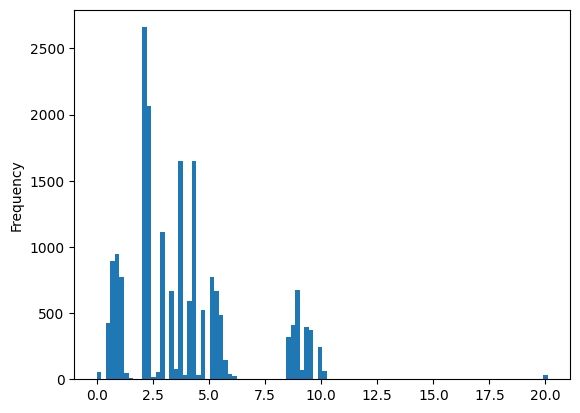

In [12]:
df.Total_UNCY = df.Total_UNCY.astype(float)
df.Total_UNCY.plot.hist(bins=100)

In [13]:
df.groupby("filename").Total_UNCY.mean().sort_values(ascending=False).head(50)

filename
Retrolens/Marlborough/CloudyBay/Shorelines/CloudyBay_02FEB2016.shp                     20.106837
Retrolens/Marlborough/WairauRiver/Shorelines/WairauRiver_07JAN2016.shp                 20.051572
Retrolens/Marlborough/CliffordBay/Shorelines/CliffordBay_07JAN2016.shp                 20.023509
Retrolens/Nelson/BoulderBank/Shorelines/BoulderBank_06FEB1967.shp                      10.502980
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_04FEB1967.shp                      10.483475
Retrolens/Manawatu/HokioBeach/Shorelines/HokioBeach_30NOV1978.shp                      10.098465
Retrolens/Southland/MasonsBay/Shorelines/MasonsBay_10DEC1958.shp                       10.083394
Retrolens/Marlborough/CloudyBay/Shorelines/CloudyBay_04DEC2000.shp                     10.061047
Retrolens/HawkesBay/BayView/Shorelines/Bayview_17DEC1996.shp                           10.055990
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_31JAN1980.shp                      10.052659
Retrolens/Bay of Plen

In [14]:
df.groupby("Source").Total_UNCY.mean().sort_values(ascending=False).head(50)

Source
RS     6.813094
RL     5.318953
CRI    5.066792
RLS    4.916569
RLN    4.908844
Rl     3.714563
NEO    3.594012
JIL    3.095256
MAX    3.060377
PLE    3.004044
SAT    2.975786
Max    2.340865
JIN    2.331288
max    2.277971
WV3    2.260818
PNE    2.256973
LDS    2.202026
GE1    2.196865
VEX    2.162227
Name: Total_UNCY, dtype: float64

In [15]:
df.Photoscale.value_counts()

Photoscale
25000.0    1272
16000.0    1037
50000.0     605
44500.0     501
24000.0     442
           ... 
11600.0       2
18800.0       2
18850.0       1
19600.0       1
8300.0        1
Name: count, Length: 99, dtype: int64

In [16]:
df.Georef_ER.value_counts(dropna=False)

Georef_ER
2.02        5517
0           4240
3.61        2711
4.2         2563
5.03        2464
2.596504    1568
None         391
Name: count, dtype: int64